In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from harmonypy import run_harmony
from ALLCools.mcds import MCDS
from ALLCools.clustering import significant_pc_test, tsne, log_scale, balanced_pca, calculate_direct_confusion
from ALLCools.plot import *

## Load HVFs

In [2]:
hvfs = pd.read_csv('hvgs.txt', header=None, index_col=0).index
hvfs.size

618

## Load Adata, Select HVF, Scale Features

In [3]:
tenx_adata = anndata.read_h5ad('./preprocess_10X/PseudoCellAdata.norm_log1p.h5ad')

tenx_adata = tenx_adata[:, hvfs].copy()

sc.pp.scale(tenx_adata)
tenx_adata

AnnData object with n_obs × n_vars = 3679 × 618
    obs: 'n_cells', 'SubType', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

In [4]:
smart_adata = anndata.read_h5ad('./preprocess_SMART/TotalAdata.norm_log1p.h5ad')
smart_adata = smart_adata[:, hvfs].copy()

sc.pp.scale(smart_adata)
smart_adata

AnnData object with n_obs × n_vars = 4051 × 618
    obs: 'MajorType', 'SubType', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    layers: 'raw'

In [5]:
atac_adata = anndata.read_h5ad('./preprocess_snATAC/PseudoCellAdata.norm_log1p.h5ad')
atac_adata = atac_adata[:, hvfs].copy()

sc.pp.scale(atac_adata)
atac_adata

AnnData object with n_obs × n_vars = 5026 × 618
    obs: 'n_cells', 'SubType', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

In [6]:
snmc_adata = anndata.read_h5ad('../input/snmC.Neuron.gene_CHN_fracs.h5ad')
snmc_adata = snmc_adata[:, hvfs].copy()

sc.pp.scale(snmc_adata)
snmc_adata.X *= -1
snmc_adata

AnnData object with n_obs × n_vars = 8717 × 618
    obs: 'MajorType', 'SubType'
    var: 'mean', 'std'

In [7]:
snm3c_adata = anndata.read_h5ad('../input/snm3C.Neuron.gene_CHN_fracs.h5ad')
snm3c_adata = snm3c_adata[:, hvfs].copy()

sc.pp.scale(snm3c_adata)
snm3c_adata.X *= -1
snm3c_adata

AnnData object with n_obs × n_vars = 3097 × 618
    obs: 'MajorType', 'SubType'
    var: 'mean', 'std'

## Concatenate All Datasets

In [8]:
adata = smart_adata.concatenate([
    snmc_adata,
    tenx_adata,
    snm3c_adata,
    atac_adata,
],
                                index_unique='-')
adata.obs['batch'] = adata.obs['batch'].map({
    '0': 'SMART',
    '1': 'snmC',
    '2': '10X',
    '3': 'snm3C',
    '4': 'snATAC',
})
adata

AnnData object with n_obs × n_vars = 24570 × 618
    obs: 'MajorType', 'SubType', 'n_genes', 'n_counts', 'n_cells', 'batch'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'mean-1', 'std-1', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'mean-2', 'std-2', 'mean-3', 'std-3', 'highly_variable-4', 'means-4', 'dispersions-4', 'dispersions_norm-4', 'mean-4', 'std-4'

## PCA and Harmony Correction

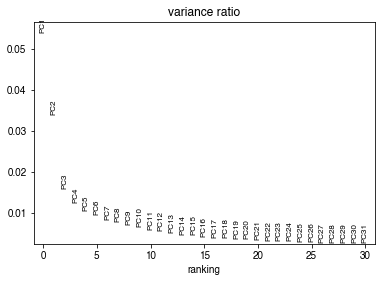

19 components passed P cutoff of 0.2.
Changing adata.obsm['X_pca'] from shape (24570, 100) to (24570, 19)


In [9]:
sc.pp.pca(adata, n_comps=100)
sc.pl.pca_variance_ratio(adata)
n_components = significant_pc_test(adata, p_cutoff=0.2)

In [10]:
ho = run_harmony(adata.obsm['X_pca'],
                 meta_data=adata.obs,
                 vars_use='batch',
                 random_state=0,
                 nclust=100,
                 max_iter_harmony=20)
adata.obsm['X_pca'] = ho.Z_corr.T

2021-10-03 15:14:00,825 - harmonypy - INFO - Iteration 1 of 20
2021-10-03 15:14:13,161 - harmonypy - INFO - Iteration 2 of 20
2021-10-03 15:14:24,582 - harmonypy - INFO - Iteration 3 of 20
2021-10-03 15:14:36,290 - harmonypy - INFO - Iteration 4 of 20
2021-10-03 15:14:47,609 - harmonypy - INFO - Converged after 4 iterations


Red axis labels are used PCs


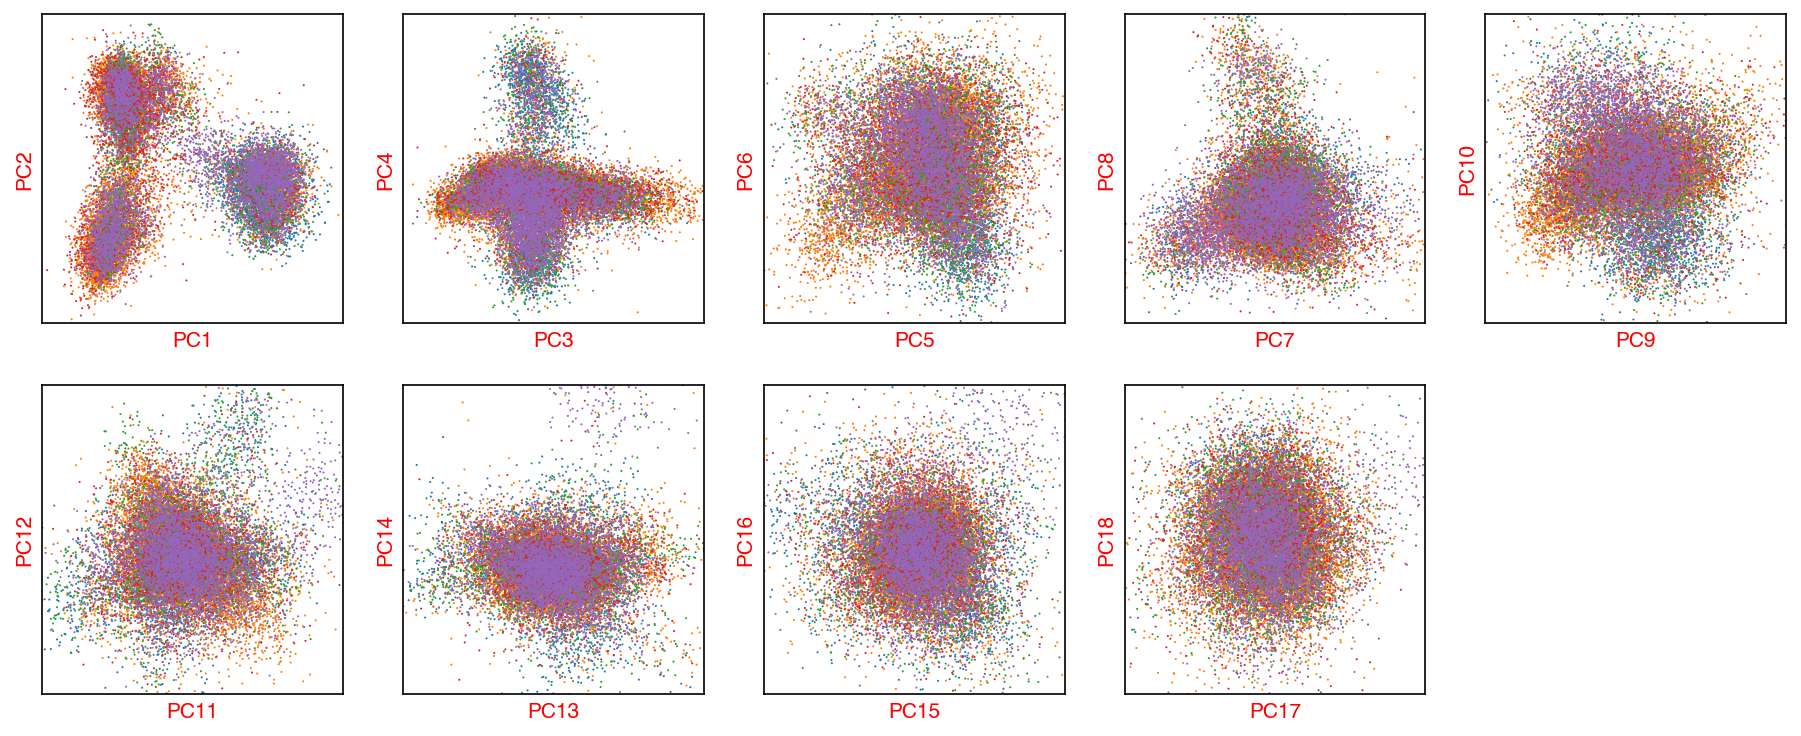

In [11]:
_ = plot_decomp_scatters(adata,
                         n_components=n_components,
                         hue='batch',
                         palette='tab10')

## Co-Clustering

In [12]:
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.leiden(adata, resolution=1)

In [13]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [14]:
sc.tl.umap(adata)
dump_embedding(adata, 'umap')

## Plot results

### Plot co-embedding and co-clusters

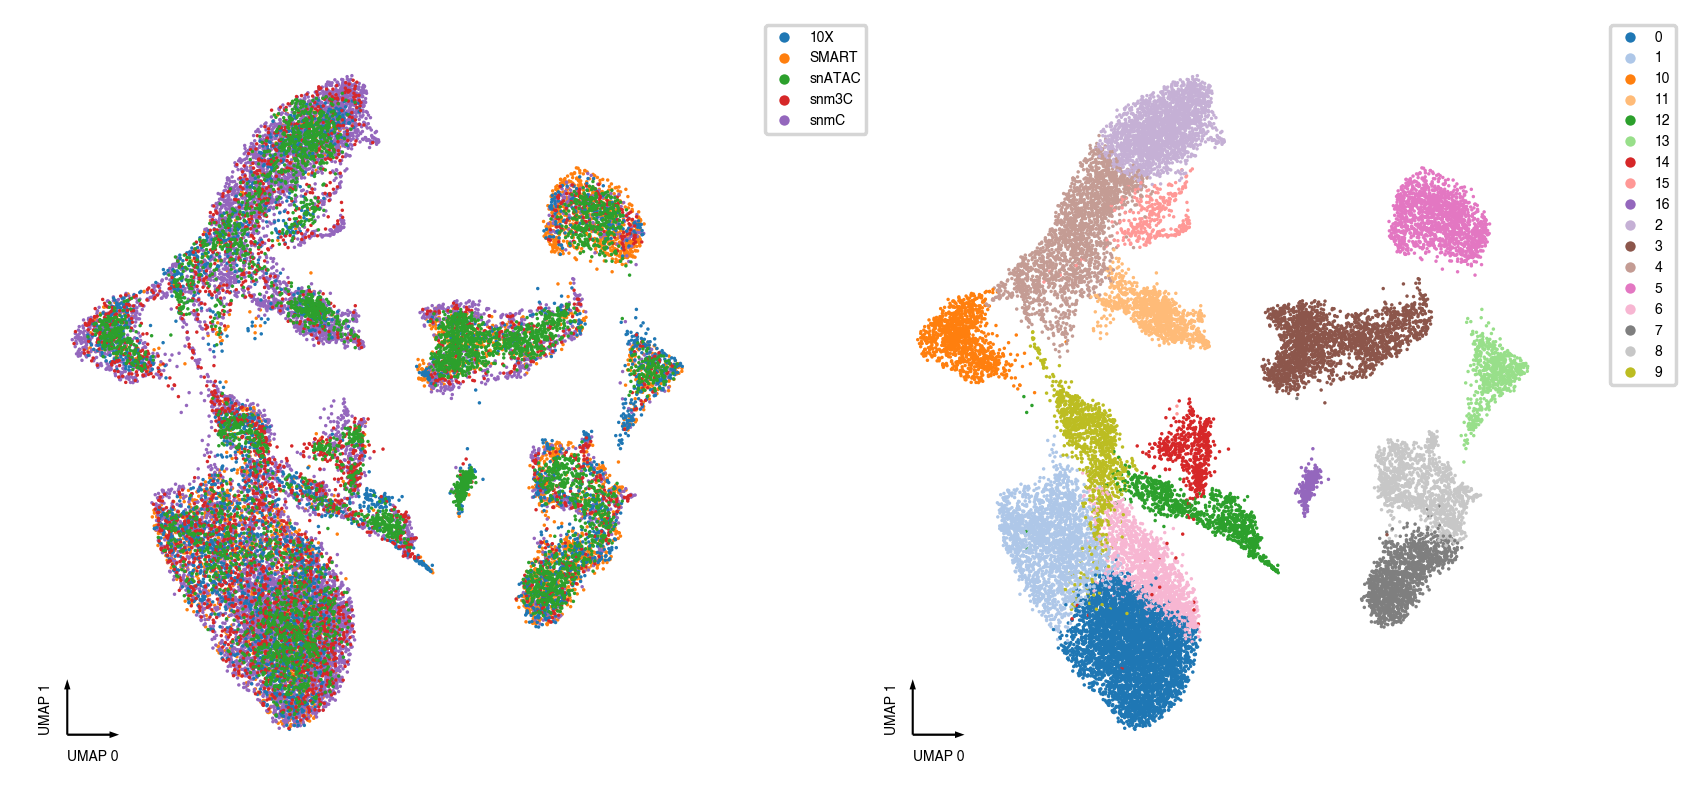

In [15]:
fig, axes = plt.subplots(figsize=(8, 4), dpi=250, ncols=2)

ax = axes[0]
_ = categorical_scatter(ax=ax,
                        data=adata.obs,
                        hue='batch',
                        show_legend=True,
                        max_points=None,
                        s=1)

ax = axes[1]
_ = categorical_scatter(ax=ax,
                        data=adata.obs,
                        hue='leiden',
                        show_legend=True,
                        max_points=None,
                        s=1)

### Plot Individual Datasets and Intra-dataset labels

All the cluster labels below were identified independently within each individual dataset.

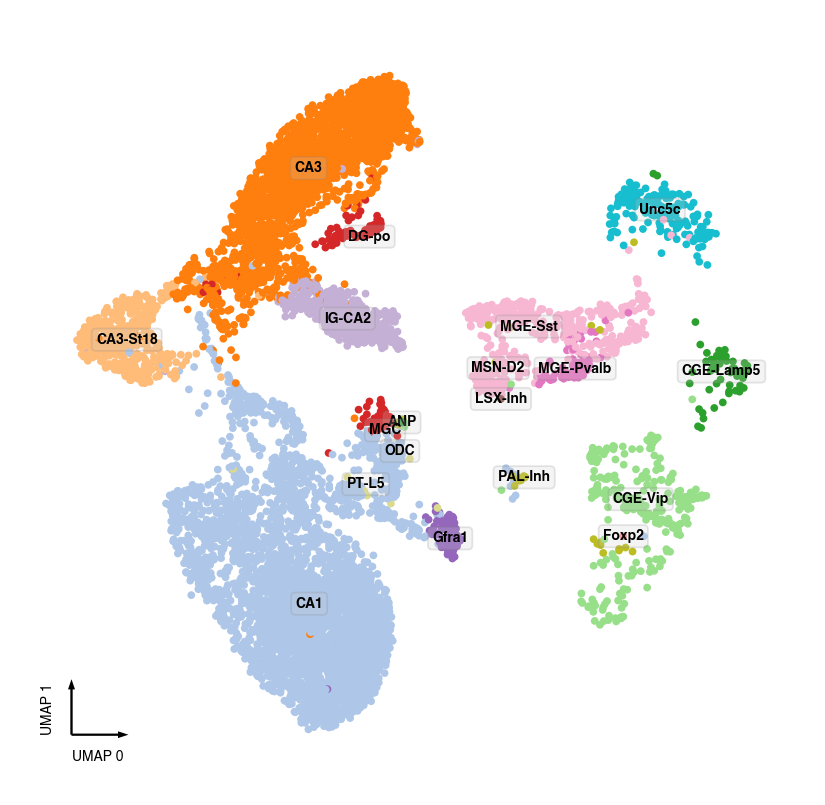

In [16]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)

data = adata.obs[adata.obs['batch'] == 'snmC'].copy()
_ = categorical_scatter(ax=ax,
                        data=data,
                        hue='MajorType',
                        show_legend=False,
                        max_points=None,
                        text_anno='MajorType',
                        s=5)

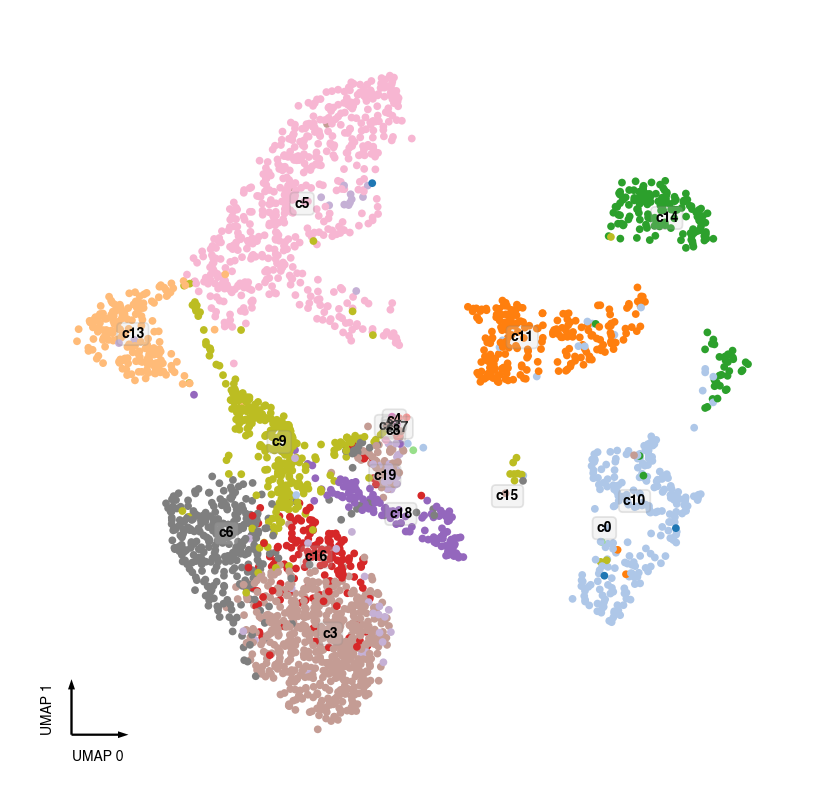

In [17]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)

data = adata.obs[adata.obs['batch'] == 'snm3C'].copy()
_ = categorical_scatter(ax=ax,
                        data=data,
                        hue='MajorType',
                        show_legend=False,
                        max_points=None,
                        text_anno='MajorType',
                        s=5)

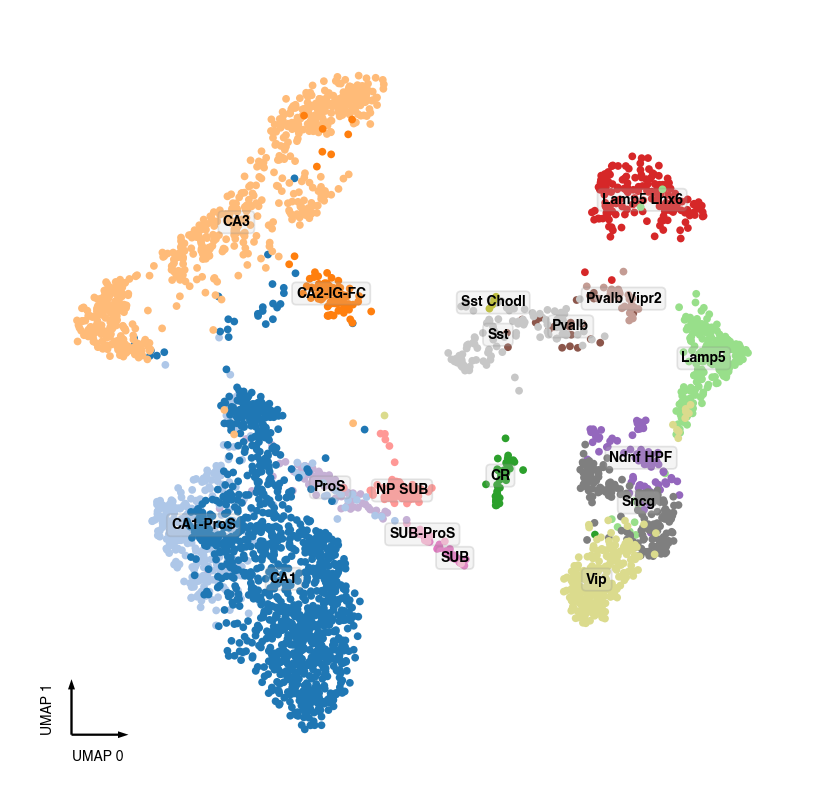

In [18]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)

data = adata.obs[adata.obs['batch'] == '10X'].copy()
data['MajorType'] = data['SubType'].str.split('_').str[-1]
_ = categorical_scatter(ax=ax,
                        data=data,
                        hue='MajorType',
                        show_legend=False,
                        max_points=None,
                        text_anno='MajorType',
                        s=5)

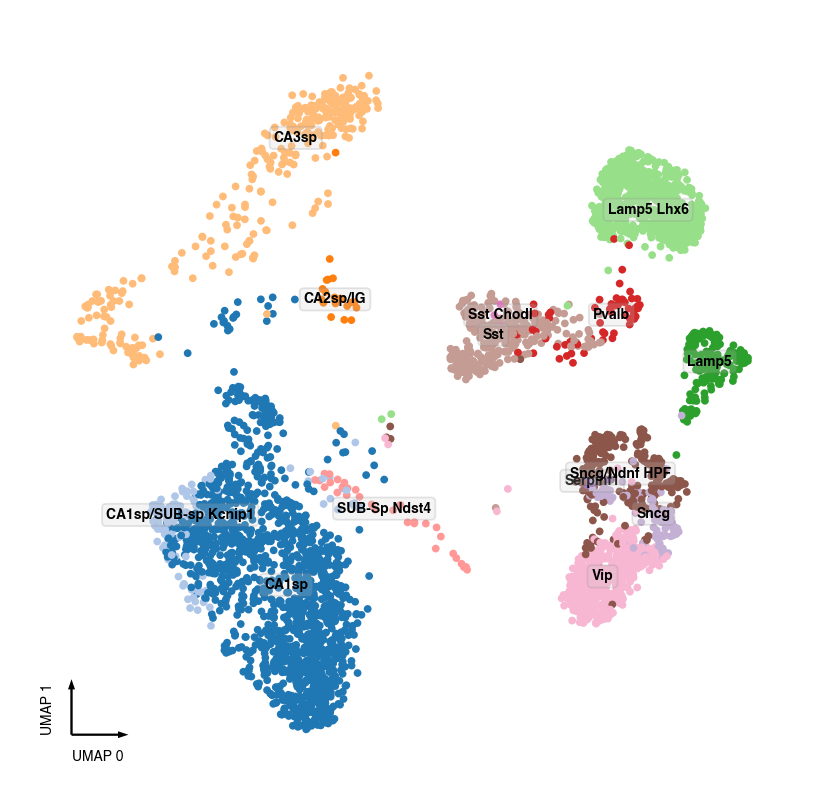

In [19]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)

data = adata.obs[adata.obs['batch'] == 'SMART'].copy()
_ = categorical_scatter(ax=ax,
                        data=data,
                        hue='MajorType',
                        show_legend=False,
                        max_points=None,
                        text_anno='MajorType',
                        s=5)

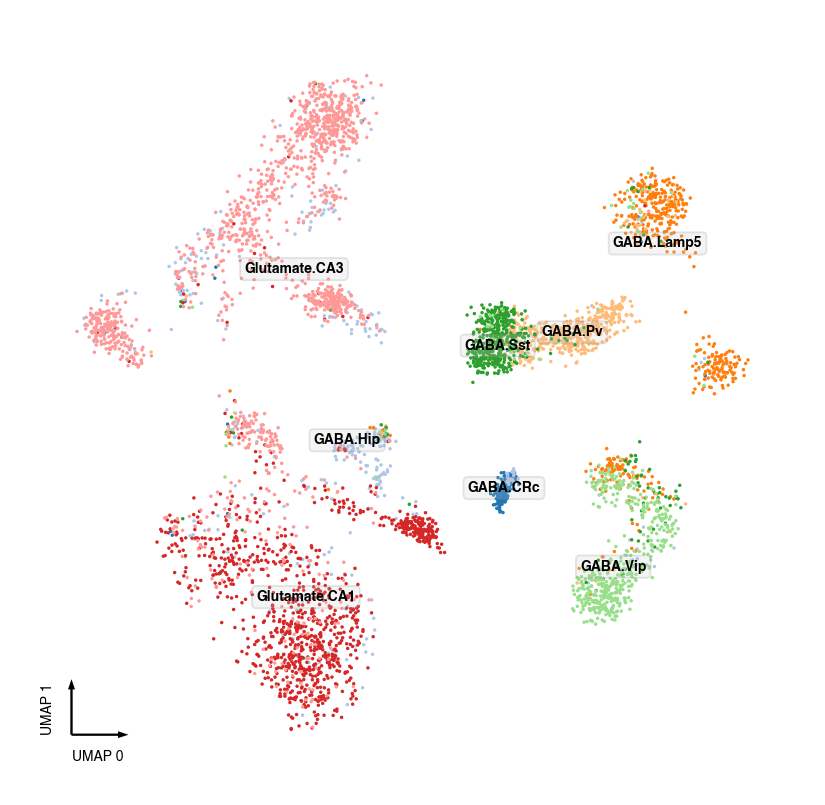

In [22]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)

data = adata.obs[adata.obs['batch'] == 'snATAC'].copy()
data['MajorType'] = data['SubType'].apply(lambda i: '.'.join(i.split('.')[:2]))
_ = categorical_scatter(ax=ax,
                        data=data,
                        hue='MajorType',
                        show_legend=False,
                        max_points=None,
                        text_anno='MajorType',
                        palette='tab20',
                        s=1)